In [58]:
from dask.distributed import Client

client = Client("tcp://10.32.16.35:39723")
client

Client Scheduler: tcp://10.32.16.35:39723 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 19 Cores: 38 Memory: 218.50 GB


# WOA Data
To compare with SOSE and ECCOv4r3 products

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.ticker as mticker
import xarray as xr
import gsw
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import regionmask

In [3]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
lower_lat = -79.5
upper_lat = -61.5
left_lon = -64.5
right_lon = 30.5

In [4]:
#set the boundaries
lat_range = dict(lat=slice(lower_lat, upper_lat))
lon_range = dict(lon=slice(left_lon, right_lon))

# <span style='color:Orange'> 1981 - 2010 period

In [5]:
ds_salt = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/Avg_Decades_1981-2010/salt')
ds_temp = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/Avg_Decades_1981-2010/temp')
ds = xr.merge([ds_salt, ds_temp])
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lev: 102, lon: 360, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    san      (time, lev, lat, lon) float32 ...
    smn      (time, lev, lat, lon) float32 ...
    sdd      (time, lev, lat, lon) float32 ...
    ssd      (time, lev, lat, lon) float32 ...
    sse      (time, lev, lat, lon) float32 ...
    soa      (time, lev, lat, lon) float32 ...
    sgp      (time, lev, lat, lon) float32 ...
    tan      (time, lev, lat, lon) float32 ...
    tmn      (time, lev, lat, lon) float32 ...
    tdd      (time, lev, lat, lon) float32 ...
    tsd      (time, lev, lat, lon) float32 ...
    tse      (time, lev, lat, lon) float32 ...
    toa      (time, lev, lat, lon) float32 ...
    tgp      (time, lev, lat, lon) float32 ...

## <span style='color:Brown'> Converting __in situ__ temperature to __potential__ temperature

In [7]:
tan = ds.tan.load()

In [8]:
#change levels to pressure
pressure = xr.apply_ufunc(gsw.p_from_z, tan.lev, ds.lat, 
                          output_dtypes=[float, ],
                          dask='parallelized').reset_coords(drop=True).load()
pressure.name = 'pressure'

In [9]:
#change practical salinity [psu] to absolute salinity [g/kg]
sa = xr.apply_ufunc(gsw.SA_from_SP, ds.san, pressure, ds.lon, ds.lat,
                    output_dtypes=[ds.san.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa.name = 'SA'

In [10]:
pt = xr.apply_ufunc(gsw.pt0_from_t, sa, tan, pressure,
                    output_dtypes=[tan.dtype],
                    dask='parallelized').reset_coords(drop=True)
pt.name = 'PT'

## <span style='color:Brown'> Bottom Potential Temperatures

In [12]:
# this gives us the depth of the bottom cell
lev_max = pt.lev.where(pt.notnull()).max(dim='lev')
# which we can use as an indexer
pt_bottom = pt.sel(lev=lev_max.fillna(0.))

In [13]:
pt_bottom_wg = pt_bottom.sel(**lat_range, **lon_range)

In [14]:
surface_mask_pt = (pt_bottom_wg.notnull()).load()

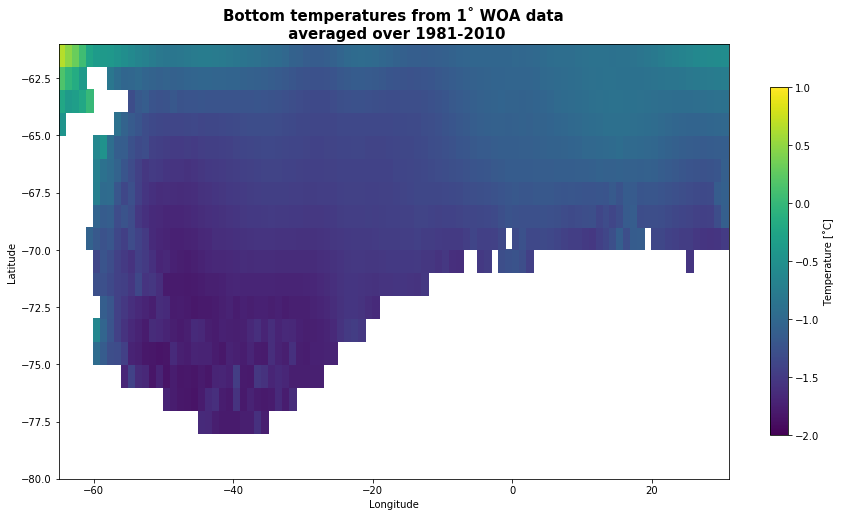

In [15]:
pt_bottom_wg.where(surface_mask_pt).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Temperature [˚C]'}, vmin=-2, vmax=1)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom temperatures from 1˚ WOA data\n averaged over 1981-2010', fontsize=15, weight='bold');

##  <span style='color:Magenta'> Plotting w Cartopy

In [17]:
pt_bottom_wg = xr.open_dataset('/home/jovyan/WMT/WOA/pt_bottom_wg_8110.nc')
pt_bottom_wg

<xarray.Dataset>
Dimensions:  (lat: 19, lon: 96, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lev      (time, lat, lon) float64 ...
  * lat      (lat) float64 -79.5 -78.5 -77.5 -76.5 ... -64.5 -63.5 -62.5 -61.5
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 27.5 28.5 29.5 30.5
Data variables:
    PT       (time, lat, lon) float64 ...

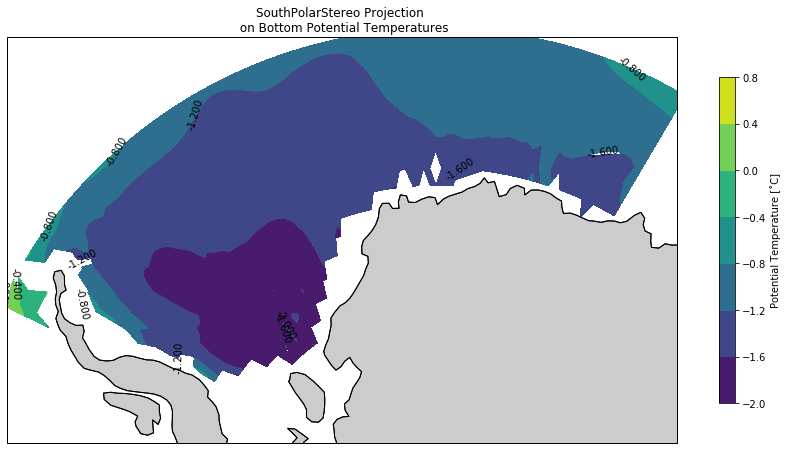

In [17]:
proj = ccrs.SouthPolarStereo()


fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=proj)
ax.set_extent([-65, 30, -80, -62], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')
C = ax.contourf(pt_bottom_wg.lon, pt_bottom_wg.lat, pt_bottom_wg.PT[0], transform=ccrs.PlateCarree())
fig.colorbar(C, shrink=0.4, label='Potential Temperature [˚C]')
#ax.set_yticks(np.arange(-79.5,-61.5,2))
#ax.set_xticks(np.arange(-64.5,30.5,10))
ax.clabel(C, colors='k')
plt.title('SouthPolarStereo Projection \n on Bottom Potential Temperatures');

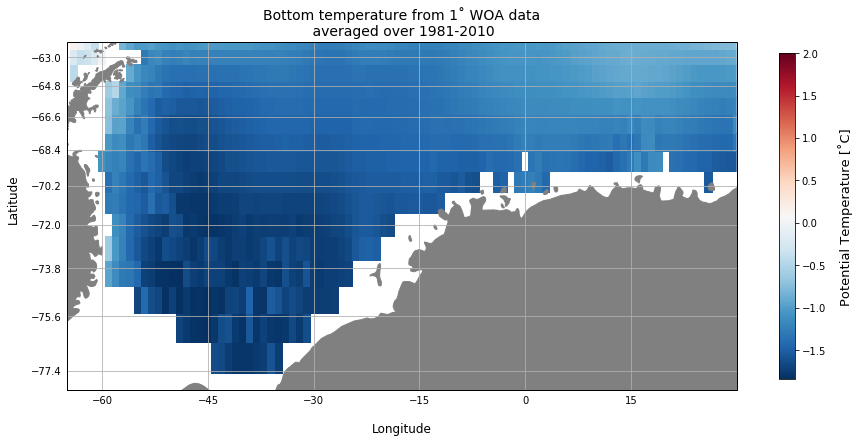

In [18]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
#ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))#cfeature.COLORS['land']))

#C = ax.contourf(pt_bottom_wg.lon, pt_bottom_wg.lat, pt_bottom_wg.PT[0], transform=ccrs.PlateCarree())#, levels=np.arange(-2, 1, 0.2))
#ax.clabel(C, colors='k')
#fig.colorbar(C, ax=ax, shrink=0.4, label='Potential Temperature [˚C]')
im = ax.pcolormesh(pt_bottom_wg.lon, pt_bottom_wg.lat, pt_bottom_wg.PT[0], transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

#ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
#basins = regionmask.defined_regions.natural_earth.ocean_basins_50
#mask = basins.mask(pt_bottom_wg.lon, pt_bottom_wg.lat)
#mask.plot(add_colorbar=False, ax=ax);
#ax.set_xlim(xmin=-78)
plt.title('Bottom temperature from 1˚ WOA data\n averaged over 1981-2010', fontsize=14);

## <span style='color:Red'> Bottom Temperature Error (start)

In [40]:
ds.tse

<xarray.DataArray 'tse' (time: 1, lev: 102, lat: 180, lon: 360)>
[6609600 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:  standard error about the statistical mean sea water temperatu...

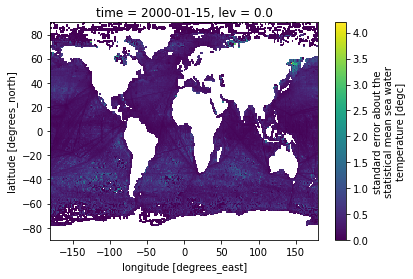

In [41]:
ds.tse[0,0].plot()

In [42]:
pt_error = xr.apply_ufunc(gsw.pt0_from_t, sa, ds.tse, pressure,
                    output_dtypes=[ds.tse.dtype],
                    dask='parallelized').reset_coords(drop=True)
pt_error.name = 'PT_error'

## <span style='color:Brown'> Bottom Potential Temperature Error

In [43]:
pt_error

<xarray.DataArray 'PT_error' (time: 1, lev: 102, lat: 180, lon: 360)>
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
          0.        , 0.        ],
         [0.02230921,        nan,        nan, ...,        nan,
          0.        ,        nan],
         [       nan, 0.        ,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
          0.00013101, 0.00013104],
         [0.02226765,        nan,        nan, ...,        nan,
          0.00013413,        nan],
         [       nan, 0.0001387 ,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        ...,

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]]]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5

In [44]:
# this gives us the depth of the bottom cell
lev_max_error = pt_error.lev.where(pt_error.notnull()).max(dim='lev')
# which we can use as an indexer
pt_bottom_error = pt_error.sel(lev=lev_max_error.fillna(0.))

In [45]:
pt_bottom_wg_error = pt_bottom_error.sel(**lat_range, **lon_range)

In [46]:
surface_mask_pt_error = (pt_bottom_wg_error.notnull()).load()

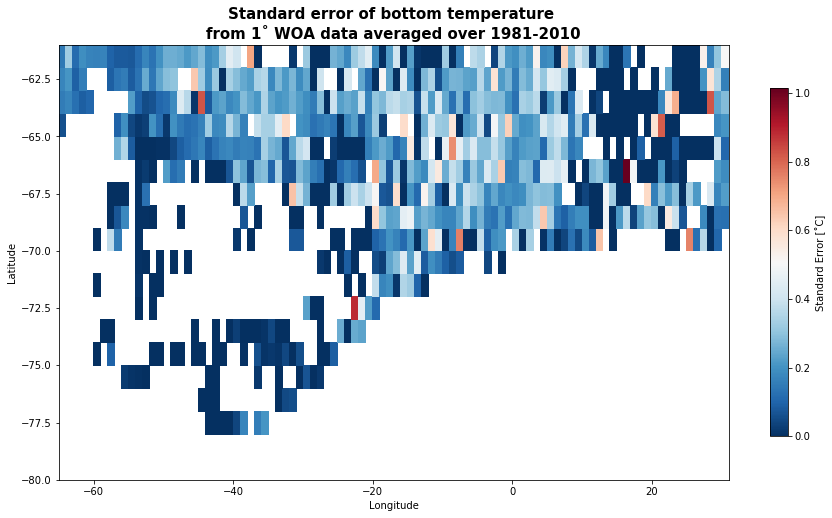

In [94]:
pt_bottom_wg_error.where(surface_mask_pt_error).plot(figsize=(15,8), cmap='RdBu_r',
                                                     cbar_kwargs={'shrink':0.8, 'label':'Standard Error [˚C]'})#, vmin=-2, vmax=1)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Standard error of bottom temperature \nfrom 1˚ WOA data averaged over 1981-2010', fontsize=15, weight='bold');

##  <span style='color:Magenta'> Plotting w Cartopy

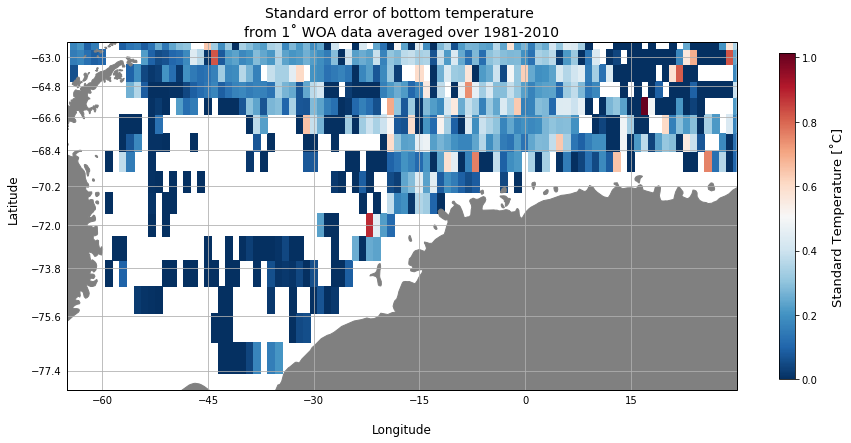

In [93]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(pt_bottom_wg_error.lon, pt_bottom_wg_error.lat, pt_bottom_wg_error[0], transform=ccrs.PlateCarree(), cmap='RdBu_r')#, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
plt.title('Standard error of bottom temperature \nfrom 1˚ WOA data averaged over 1981-2010', fontsize=14);

## <span style='color:Red'> Bottom Temperature Error (end)

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [108]:
pt_std = xr.apply_ufunc(gsw.pt0_from_t, sa, ds.tsd, pressure,
                    output_dtypes=[ds.tse.dtype],
                    dask='parallelized').reset_coords(drop=True)
pt_std.name = 'PT_std'

## <span style='color:Brown'> Bottom Potential Temperature STD

In [109]:
pt_std

<xarray.DataArray 'PT_std' (time: 1, lev: 102, lat: 180, lon: 360)>
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
          0.        , 0.        ],
         [0.03154999,        nan,        nan, ...,        nan,
          0.        ,        nan],
         [       nan, 0.        ,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
          0.00013101, 0.00013104],
         [0.03143563,        nan,        nan, ...,        nan,
          0.00013413,        nan],
         [       nan, 0.0001387 ,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        ...,

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]]]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 1

In [110]:
# this gives us the depth of the bottom cell
lev_max_std = pt_std.lev.where(pt_std.notnull()).max(dim='lev')
# which we can use as an indexer
pt_bottom_std = pt_std.sel(lev=lev_max_std.fillna(0.))

In [111]:
pt_bottom_wg_std = pt_bottom_std.sel(**lat_range, **lon_range)

In [112]:
surface_mask_pt_std = (pt_bottom_wg_std.notnull()).load()

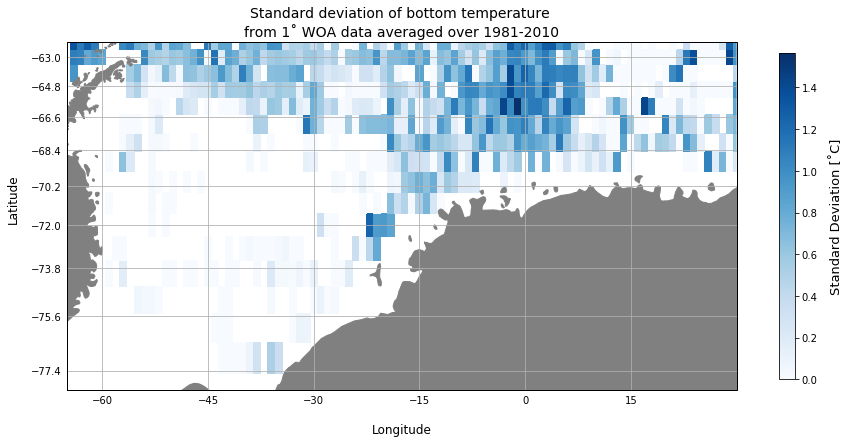

In [127]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(pt_bottom_wg_std.lon, pt_bottom_wg_std.lat, pt_bottom_wg_std[0], transform=ccrs.PlateCarree(), cmap='Blues')#, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
plt.title('Standard deviation of bottom temperature \nfrom 1˚ WOA data averaged over 1981-2010', fontsize=14);

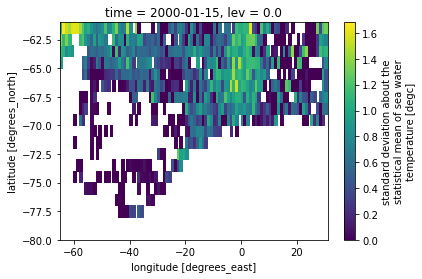

In [125]:
#does this mean yellow is 1.6˚C away from the mean temp - or 1.6 std units away meaning it would lie somewhere w/in 95% of the data distribution
ds.tsd[0,0].sel(**lat_range, **lon_range).plot()

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)

## <span style='color:Brown'> Bottom Practical Salinities

In [19]:
# this gives us the depth of the bottom cell
lev_max_slt = ds.san.lev.where(ds.san.notnull()).max(dim='lev')
# which we can use as an indexer
san_bottom = ds.san.sel(lev=lev_max_slt.fillna(0.))

In [20]:
san_bottom_wg = san_bottom.sel(**lat_range, **lon_range)

In [21]:
surface_mask_san = (san_bottom_wg.notnull()).load()

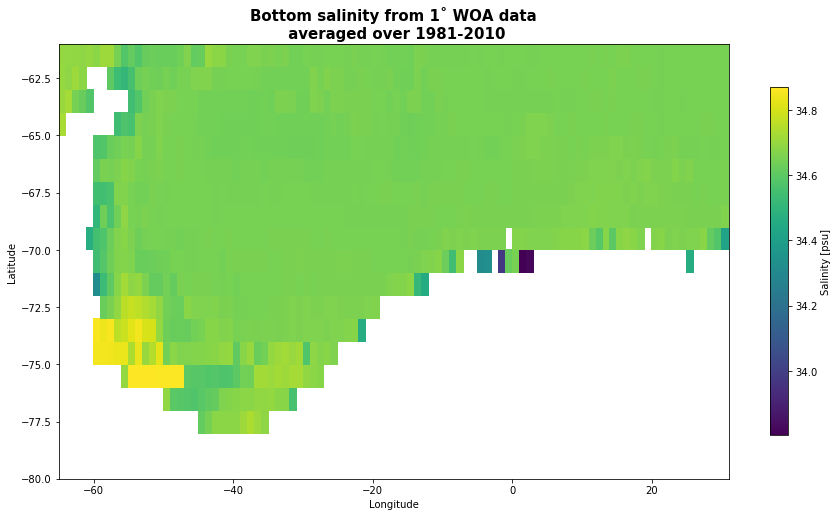

In [22]:
san_bottom_wg.where(surface_mask_san).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Salinity [psu]'})
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom salinity from 1˚ WOA data\n averaged over 1981-2010', fontsize=15, weight='bold');

##  <span style='color:Magenta'> Plotting w Cartopy

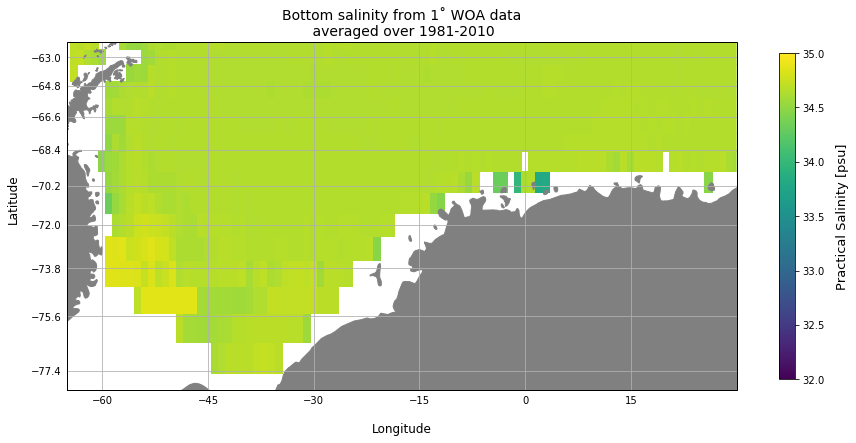

In [23]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(san_bottom_wg.lon, san_bottom_wg.lat, san_bottom_wg[0], cmap='viridis', vmin=32, vmax=35, transform=ccrs.PlateCarree())

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Practical Salinity [psu]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from 1˚ WOA data\n averaged over 1981-2010', fontsize=14, );

## <span style='color:Red'> Bottom Salinity Error (start)

In [55]:
ds.sse

<xarray.DataArray 'sse' (time: 1, lev: 102, lat: 180, lon: 360)>
[6609600 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:  standard error about the statistical mean sea water salinity ...

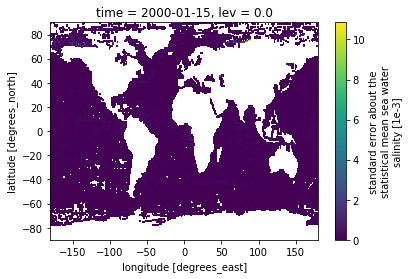

In [56]:
ds.sse[0,0].plot()

## <span style='color:Brown'> Bottom Practical Salinity Error

In [57]:
# this gives us the depth of the bottom cell
lev_max_slt_error = ds.sse.lev.where(ds.sse.notnull()).max(dim='lev')
# which we can use as an indexer
san_bottom_error = ds.sse.sel(lev=lev_max_slt_error.fillna(0.))

In [59]:
san_bottom_wg_error = san_bottom_error.sel(**lat_range, **lon_range)

In [60]:
surface_mask_san_error = (san_bottom_wg_error.notnull()).load()

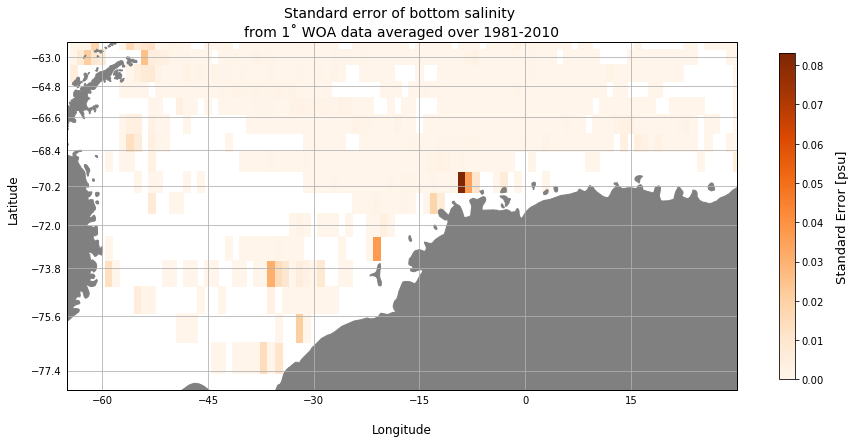

In [135]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(san_bottom_wg_error.lon, 
                   san_bottom_wg_error.lat, 
                   san_bottom_wg_error[0], cmap='Oranges', transform=ccrs.PlateCarree())

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Standard Error [psu]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard error of bottom salinity \nfrom 1˚ WOA data averaged over 1981-2010', fontsize=14, );

## <span style='color:Red'> Bottom Salinity Error (end)

## <span style='color:Red'> Bottom Salinity Standard Deviation (start)

## <span style='color:Brown'> Bottom Practical Salinity STD

In [128]:
# this gives us the depth of the bottom cell
lev_max_slt_std = ds.ssd.lev.where(ds.ssd.notnull()).max(dim='lev')
# which we can use as an indexer
san_bottom_std = ds.ssd.sel(lev=lev_max_slt_std.fillna(0.))

In [129]:
san_bottom_wg_std = san_bottom_std.sel(**lat_range, **lon_range)

In [130]:
surface_mask_san_std = (san_bottom_wg_std.notnull()).load()

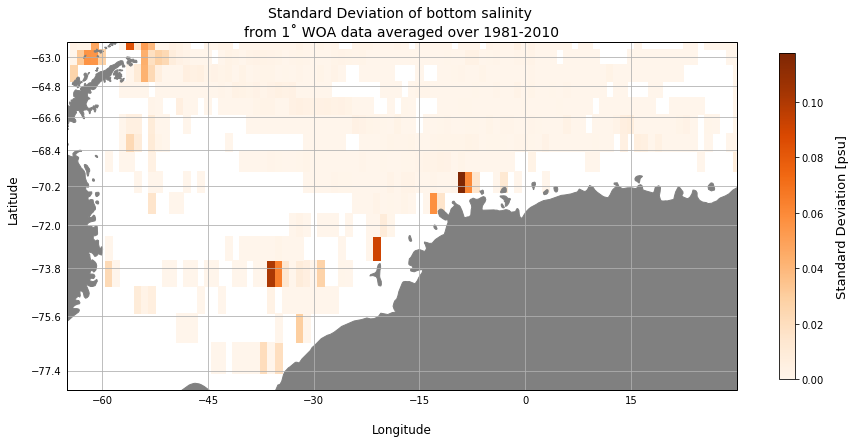

In [134]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(san_bottom_wg_std.lon, 
                   san_bottom_wg_std.lat, 
                   san_bottom_wg_std[0], cmap='Oranges', transform=ccrs.PlateCarree())

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Standard Deviation [psu]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard Deviation of bottom salinity \nfrom 1˚ WOA data averaged over 1981-2010', fontsize=14, );

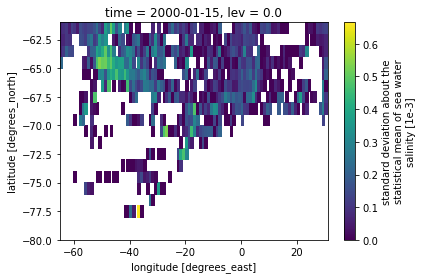

In [133]:
#does this mean yellow is 1.6˚C away from the mean temp - or 1.6 std units away meaning it would lie somewhere w/in 95% of the data distribution
ds.ssd[0,0].sel(**lat_range, **lon_range).plot()

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)

# <span style='color:Orange'> 2005 - 2017 period

In [66]:
ds_salt_0517 = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/2005-2017/salt')
ds_temp_0517 = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/2005-2017/temp')
ds_0517 = xr.merge([ds_salt_0517, ds_temp_0517])
ds_0517

<xarray.Dataset>
Dimensions:  (lat: 180, lev: 102, lon: 360, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    san      (time, lev, lat, lon) float32 ...
    smn      (time, lev, lat, lon) float32 ...
    sdd      (time, lev, lat, lon) float32 ...
    ssd      (time, lev, lat, lon) float32 ...
    sse      (time, lev, lat, lon) float32 ...
    soa      (time, lev, lat, lon) float32 ...
    sgp      (time, lev, lat, lon) float32 ...
    tan      (time, lev, lat, lon) float32 ...
    tmn      (time, lev, lat, lon) float32 ...
    tdd      (time, lev, lat, lon) float32 ...
    tsd      (time, lev, lat, lon) float32 ...
    tse      (time, lev, lat, lon) float32 ...
    toa      (time, lev, lat, lon) float32 ...
    tgp      (time, lev, lat, lon) float32 ...

## <span style='color:Brown'> Converting __in situ__ temperature to __potential__ temperature

In [69]:
tan_0517 = ds_0517.tan.load()

In [70]:
#change levels to pressure
pressure_0517 = xr.apply_ufunc(gsw.p_from_z, tan_0517.lev, tan_0517.lat, 
                          output_dtypes=[float, ],
                          dask='parallelized').reset_coords(drop=True).load()
pressure_0517.name = 'pressure'

In [71]:
#change practical salinity [psu] to absolute salinity [g/kg]
sa_0517 = xr.apply_ufunc(gsw.SA_from_SP, ds_0517.san, pressure_0517, ds_0517.lon, ds_0517.lat,
                    output_dtypes=[ds_0517.san.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa_0517.name = 'SA'

In [72]:
pt_0517 = xr.apply_ufunc(gsw.pt0_from_t, sa_0517, tan_0517, pressure_0517,
                    output_dtypes=[tan_0517.dtype],
                    dask='parallelized').reset_coords(drop=True)
pt_0517.name = 'PT'

## <span style='color:Brown'> Bottom Potential Temperatures

In [73]:
# this gives us the depth of the bottom cell
lev_max_0517 = pt_0517.lev.where(pt_0517.notnull()).max(dim='lev')
# which we can use as an indexer
pt_bottom_0517 = pt_0517.sel(lev=lev_max_0517.fillna(0.))

In [74]:
pt_bottom_wg_0517 = pt_bottom_0517.sel(**lat_range, **lon_range)

In [75]:
surface_mask_pt_0517 = (pt_bottom_wg_0517.notnull()).load()

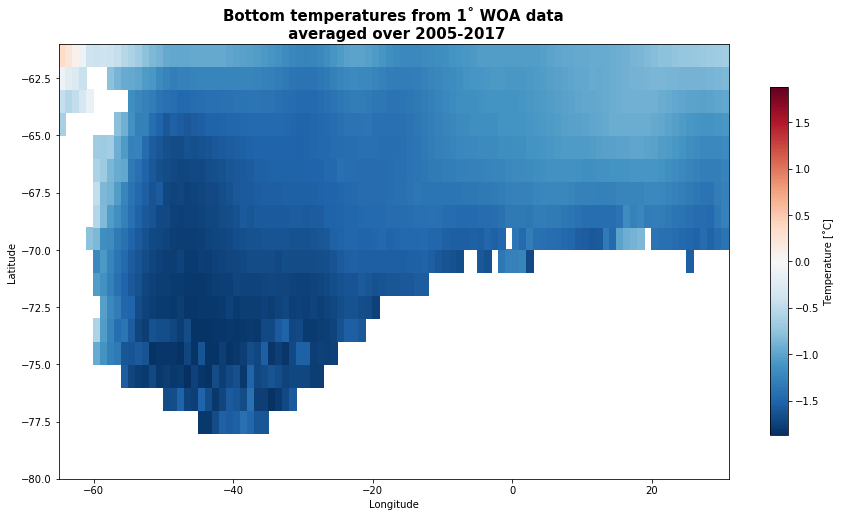

In [76]:
pt_bottom_wg_0517.where(surface_mask_pt_0517).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Temperature [˚C]'})
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom temperatures from 1˚ WOA data\n averaged over 2005-2017', fontsize=15, weight='bold');

##  <span style='color:Magenta'> Plotting w Cartopy

In [77]:
pt_bottom_wg_0517 = xr.open_dataset('/home/jovyan/WMT/WOA/pt_bottom_wg_0517.nc')
pt_bottom_wg_0517

<xarray.Dataset>
Dimensions:  (lat: 19, lon: 96, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lev      (time, lat, lon) float64 ...
  * lat      (lat) float64 -79.5 -78.5 -77.5 -76.5 ... -64.5 -63.5 -62.5 -61.5
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 27.5 28.5 29.5 30.5
Data variables:
    PT       (time, lat, lon) float64 ...

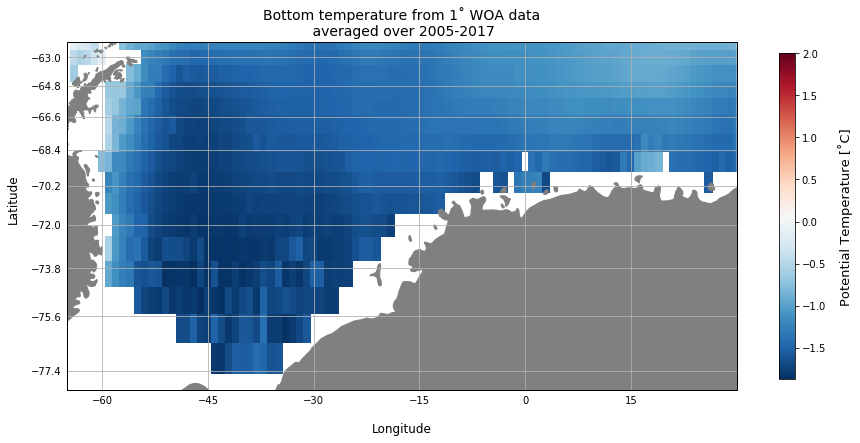

In [78]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(pt_bottom_wg_0517.lon, pt_bottom_wg_0517.lat, pt_bottom_wg_0517.PT[0], transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Potential Temperature [˚C]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from 1˚ WOA data\n averaged over 2005-2017', fontsize=14);

## <span style='color:Red'> Bottom Temperature Error (start)

In [79]:
ds_0517.tse

<xarray.DataArray 'tse' (time: 1, lev: 102, lat: 180, lon: 360)>
[6609600 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:  standard error about the statistical mean sea water temperatu...

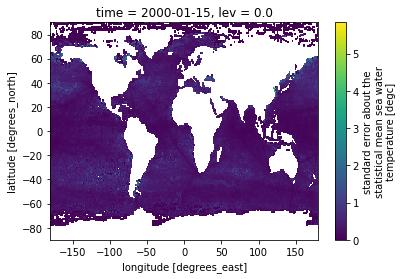

In [80]:
ds_0517.tse[0,0].plot()

In [81]:
pt_0517_error = xr.apply_ufunc(gsw.pt0_from_t, sa_0517, ds_0517.tse, pressure_0517,
                    output_dtypes=[tan_0517.dtype],
                    dask='parallelized').reset_coords(drop=True)
pt_0517_error.name = 'PT_error'

## <span style='color:Brown'> Bottom Potential Temperatures

In [82]:
# this gives us the depth of the bottom cell
lev_max_0517_error = pt_0517_error.lev.where(pt_0517_error.notnull()).max(dim='lev')
# which we can use as an indexer
pt_bottom_0517_error = pt_0517_error.sel(lev=lev_max_0517_error.fillna(0.))

In [83]:
pt_bottom_wg_0517_error = pt_bottom_0517_error.sel(**lat_range, **lon_range)

In [84]:
surface_mask_pt_0517_error = (pt_bottom_wg_0517_error.notnull()).load()

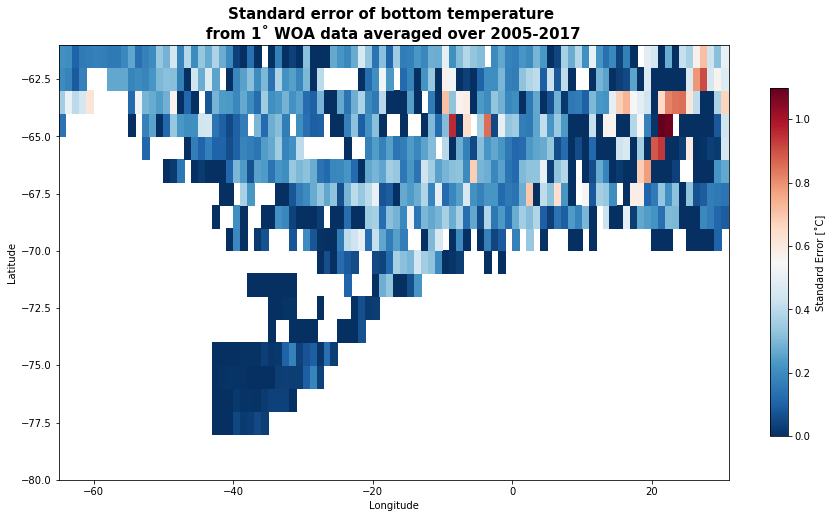

In [92]:
pt_bottom_wg_0517_error.where(surface_mask_pt_0517_error).plot(figsize=(15,8), cmap='RdBu_r',
                                                               cbar_kwargs={'shrink':0.8, 'label':'Standard Error [˚C]'})
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Standard error of bottom temperature \nfrom 1˚ WOA data averaged over 2005-2017', fontsize=15, weight='bold');

##  <span style='color:Magenta'> Plotting w Cartopy

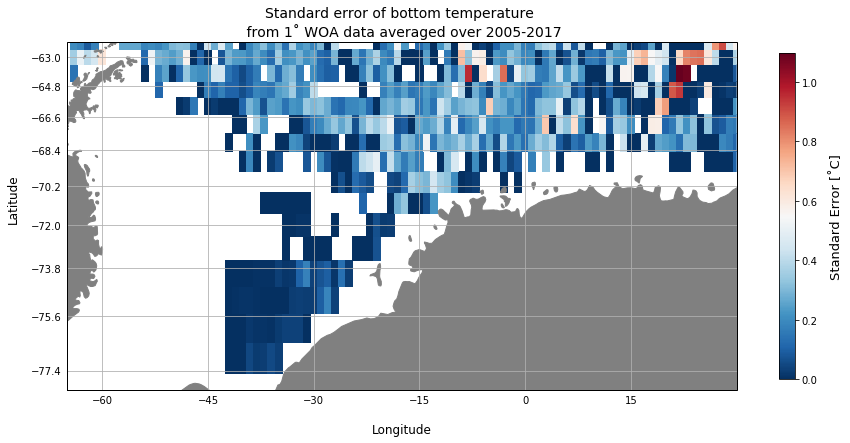

In [91]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(pt_bottom_wg_0517_error.lon, 
                   pt_bottom_wg_0517_error.lat, 
                   pt_bottom_wg_0517_error[0], cmap='RdBu_r', transform=ccrs.PlateCarree())#,vmax=2)

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Standard Error [˚C]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard error of bottom temperature \n from 1˚ WOA data averaged over 2005-2017', fontsize=14);

## <span style='color:Red'> Bottom Temperature Error (end)

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [137]:
pt_0517_std = xr.apply_ufunc(gsw.pt0_from_t, sa_0517, ds_0517.tsd, pressure_0517,
                    output_dtypes=[ds_0517.tsd.dtype],
                    dask='parallelized').reset_coords(drop=True)
pt_0517_std.name = 'PT_std'

## <span style='color:Brown'> Bottom Potential Temperature STD

In [138]:
pt_std

<xarray.DataArray 'PT_std' (time: 1, lev: 102, lat: 180, lon: 360)>
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
          0.        , 0.        ],
         [0.03154999,        nan,        nan, ...,        nan,
          0.        ,        nan],
         [       nan, 0.        ,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
          0.00013101, 0.00013104],
         [0.03143563,        nan,        nan, ...,        nan,
          0.00013413,        nan],
         [       nan, 0.0001387 ,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        ...,

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]]]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 1

In [139]:
# this gives us the depth of the bottom cell
lev_max_0517_std = pt_0517_std.lev.where(pt_0517_std.notnull()).max(dim='lev')
# which we can use as an indexer
pt_bottom_0517_std = pt_0517_std.sel(lev=lev_max_0517_std.fillna(0.))

In [140]:
pt_bottom_wg_0517_std = pt_bottom_0517_std.sel(**lat_range, **lon_range)

In [141]:
surface_mask_pt_0517_std = (pt_bottom_wg_0517_std.notnull()).load()

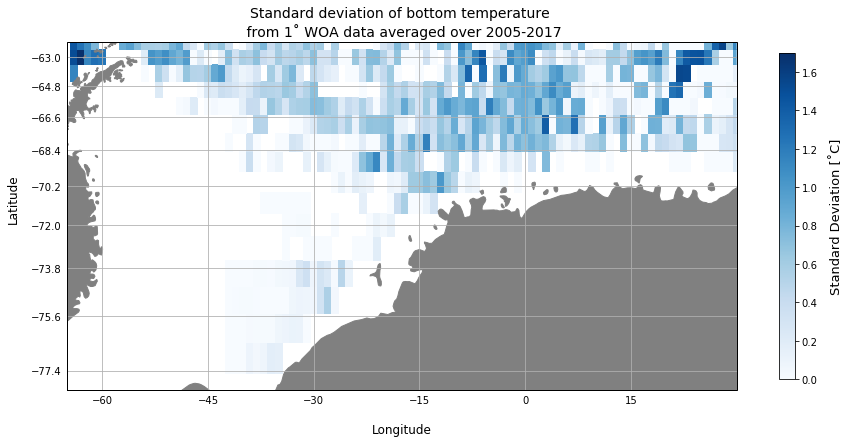

In [142]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(pt_bottom_wg_0517_std.lon, 
                   pt_bottom_wg_0517_std.lat, 
                   pt_bottom_wg_0517_std[0], cmap='Blues', transform=ccrs.PlateCarree())#,vmax=2)

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Standard Deviation [˚C]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard deviation of bottom temperature \n from 1˚ WOA data averaged over 2005-2017', fontsize=14);

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)

## <span style='color:Brown'> Bottom Practical Salinities

In [35]:
# this gives us the depth of the bottom cell
lev_max_slt_0517 = ds_0517.san.lev.where(ds_0517.san.notnull()).max(dim='lev')
# which we can use as an indexer
san_bottom_0517 = ds_0517.san.sel(lev=lev_max_slt_0517.fillna(0.))

In [36]:
san_bottom_wg_0517 = san_bottom_0517.sel(**lat_range, **lon_range)

In [37]:
surface_mask_san_0517 = (san_bottom_wg_0517.notnull()).load()

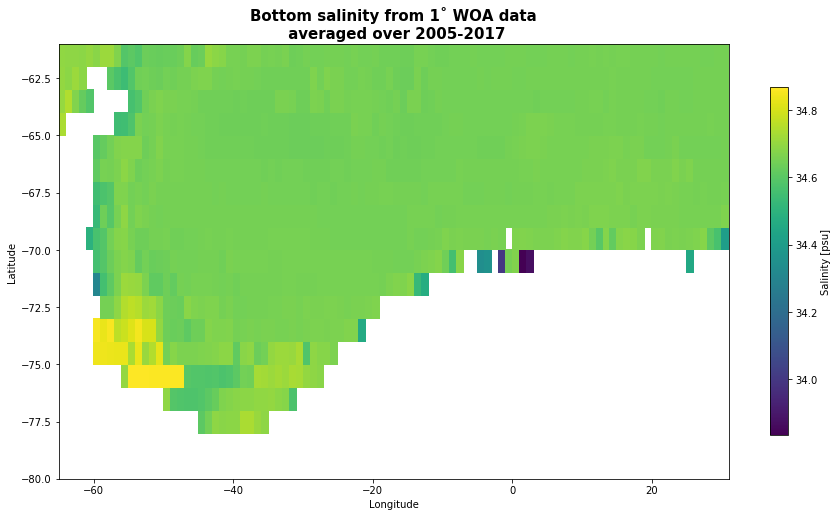

In [38]:
san_bottom_wg_0517.where(surface_mask_san_0517).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Salinity [psu]'})
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom salinity from 1˚ WOA data\n averaged over 2005-2017', fontsize=15, weight='bold');

##  <span style='color:Magenta'> Plotting w Cartopy

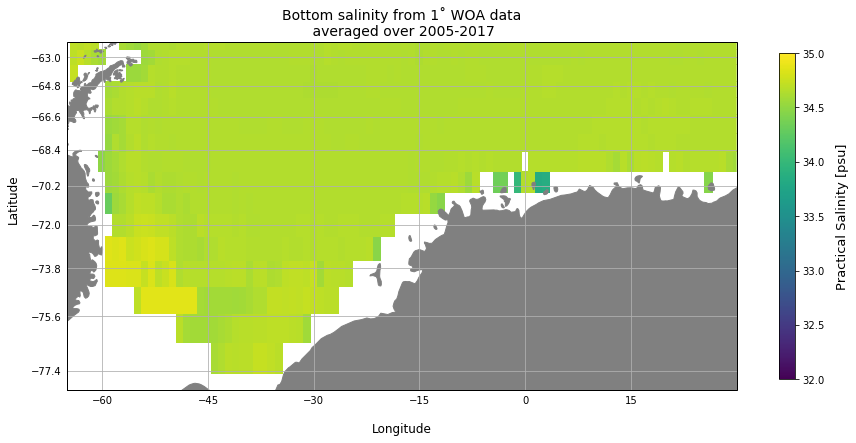

In [39]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(san_bottom_wg_0517.lon, 
                   san_bottom_wg_0517.lat, 
                   san_bottom_wg_0517[0], cmap='viridis', vmin=32, vmax=35, transform=ccrs.PlateCarree())

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Practical Salinity [psu]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from 1˚ WOA data\n averaged over 2005-2017', fontsize=14, );

## <span style='color:Red'> Bottom Salinity Error (start)

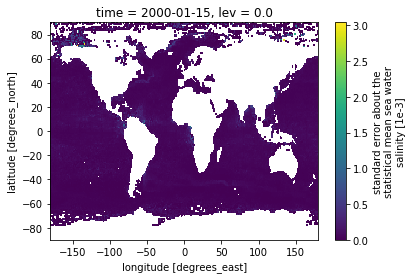

In [97]:
ds_0517.sse[0,0].plot()

## <span style='color:Brown'> Bottom Practical Salinity Error

In [98]:
# this gives us the depth of the bottom cell
lev_max_slt_0517_error = ds_0517.sse.lev.where(ds_0517.sse.notnull()).max(dim='lev')
# which we can use as an indexer
san_bottom_0517_error = ds_0517.sse.sel(lev=lev_max_slt_0517_error.fillna(0.))

In [99]:
san_bottom_wg_0517_error = san_bottom_0517_error.sel(**lat_range, **lon_range)

In [100]:
surface_mask_san_0517_error = (san_bottom_wg_0517_error.notnull()).load()

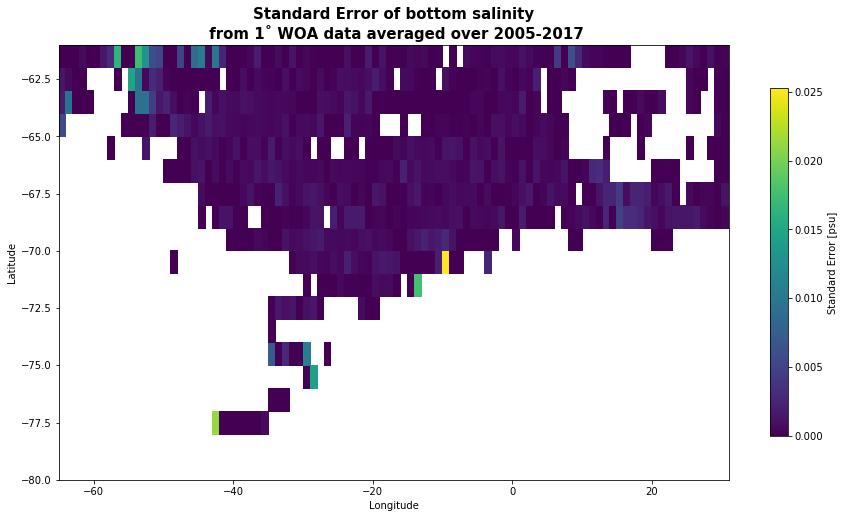

In [104]:
san_bottom_wg_0517_error.where(surface_mask_san_0517_error).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Standard Error [psu]'})
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Standard Error of bottom salinity\n from 1˚ WOA data averaged over 2005-2017', fontsize=15, weight='bold');

##  <span style='color:Magenta'> Plotting w Cartopy

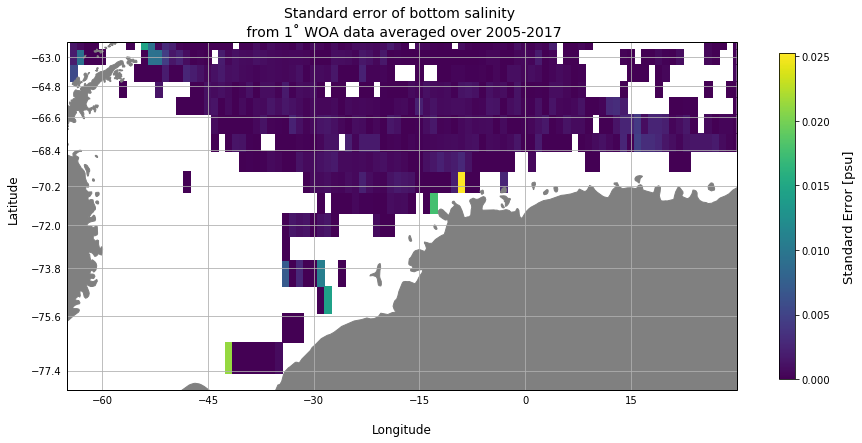

In [103]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(san_bottom_wg_0517_error.lon, 
                   san_bottom_wg_0517_error.lat, 
                   san_bottom_wg_0517_error[0], cmap='viridis', transform=ccrs.PlateCarree())

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Standard Error [psu]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard error of bottom salinity \n from 1˚ WOA data averaged over 2005-2017', fontsize=14, );

## <span style='color:Red'> Bottom Salinity Error (end)

## <span style='color:Red'> Bottom Salinity Standard Deviation (start)

## <span style='color:Brown'> Bottom Practical Salinity STD

In [143]:
# this gives us the depth of the bottom cell
lev_max_slt_0517_std = ds_0517.ssd.lev.where(ds_0517.ssd.notnull()).max(dim='lev')
# which we can use as an indexer
san_bottom_0517_std = ds_0517.ssd.sel(lev=lev_max_slt_0517_std.fillna(0.))

In [144]:
san_bottom_wg_0517_std = san_bottom_0517_std.sel(**lat_range, **lon_range)

In [145]:
surface_mask_san_0517_std = (san_bottom_wg_0517_std.notnull()).load()

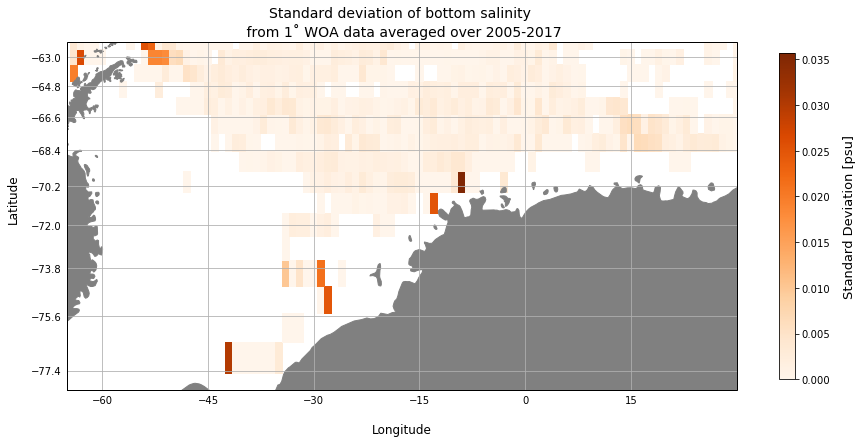

In [146]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(san_bottom_wg_0517_std.lon, 
                   san_bottom_wg_0517_std.lat, 
                   san_bottom_wg_0517_std[0], cmap='Oranges', transform=ccrs.PlateCarree())

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Standard Deviation [psu]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard deviation of bottom salinity \n from 1˚ WOA data averaged over 2005-2017', fontsize=14, );

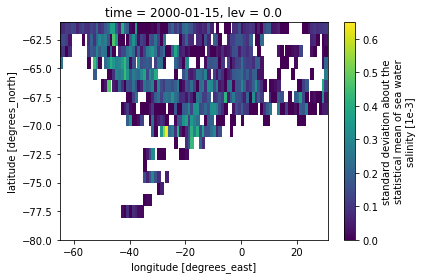

In [147]:
#does this mean yellow is 1.6˚C away from the mean temp - or 1.6 std units away meaning it would lie somewhere w/in 95% of the data distribution
ds_0517.ssd[0,0].sel(**lat_range, **lon_range).plot()

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)

# <span style='color:Gold'> THE END